<a href="https://colab.research.google.com/github/bitsym/InformerforCurve/blob/main/CurvesOT1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout, MultiHeadAttention, Input
from tensorflow.keras.models import Model
import numpy as np

class PositionalEncoding(Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)
        sines = tf.math.sin(angle_rads[:, 0::2])
        cosines = tf.math.cos(angle_rads[:, 1::2])
        pos_encoding = tf.concat([sines, cosines], axis=-1)[tf.newaxis, ...]
        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
class TransformerEncoder(Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
def build_transformer(num_features, sequence_length, d_model, num_heads, ff_dim, num_layers, rate=0.1):
    inputs = Input(shape=(sequence_length, num_features))
    # Map the input features to the model dimension
    x = Dense(d_model, activation='relu')(inputs)
    # Add positional encodings
    x = PositionalEncoding(sequence_length, d_model)(x)
    for _ in range(num_layers):
        x = TransformerEncoder(d_model, num_heads, ff_dim, rate)(x)
    outputs = Dense(1, activation='linear')(x)  # Predicting 'OT1'
    model = Model(inputs=inputs, outputs=outputs)
    return model


In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load the CSV file
data = pd.read_csv('CurvesT1.csv')

# Select features and target
features = data[['LOCATION', 'X SERIAL', 'Y SERIAL', 'Z SERIAL']]
target = data['OT1']

# Normalize the feature data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Check the sequence creation logic
def create_sequences(features, target, sequence_length):
    X, y = [], []
    for i in range(0, len(features) - sequence_length + 1, sequence_length):  # Ensure no overlap if not desired
        X.append(features[i:(i + sequence_length)])
        y.append(target[i + sequence_length - 1])  # Adjust based on how you want to predict
    return np.array(X), np.array(y)

# Assuming sequence_length is correctly set and there's enough data
features_seq, target_seq = create_sequences(features_scaled, target, sequence_length=21)
print("Generated Features Shape:", features_seq.shape)
print("Generated Target Shape:", target_seq.shape)

# Generate sequences
sequence_length = 21
features_seq, target_seq = create_sequences(features_scaled, target, sequence_length)

# Split the data into training, validation, and testing sets
# Note: Adjust indices based on how you define training, validation, and testing
index_train = len(features_seq) - 2 * sequence_length  # Reserve the last 42 sequences
index_val = len(features_seq) - sequence_length  # Reserve the last 21 sequences

train_features = features_seq[:index_train]
train_target = target_seq[:index_train]

val_features = features_seq[index_train:index_val]
val_target = target_seq[index_train:index_val]

test_features = features_seq[index_val:]
test_target = target_seq[index_val:]

# Now you can proceed to define and train your model with train_features, val_features, and test_features
# Assuming the total number of sequences and the sequence length
total_sequences = features_seq.shape[0]
train_features = features_seq[:int(total_sequences * 0.8)]
train_target = target_seq[:int(total_sequences * 0.8)]
val_features = features_seq[int(total_sequences * 0.8):int(total_sequences * 0.9)]
val_target = target_seq[int(total_sequences * 0.8):int(total_sequences * 0.9)]


Generated Features Shape: (16, 21, 4)
Generated Target Shape: (16,)


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Adjust model dimensions and architecture
d_model = 1024  # increased from 512
ff_dim = 4096   # increased from 2048
num_layers = 4  # increased from 2

model = build_transformer(num_features=4, sequence_length=21, d_model=d_model, num_heads=8, ff_dim=ff_dim, num_layers=num_layers)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Add learning rate scheduler and early stopping
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_features, train_target,
    validation_data=(val_features, val_target),
    epochs=100,
    batch_size=32,
    callbacks=[lr_scheduler, early_stopping]
)



Epoch 1/100
1/1 [==============================] - 29s 29s/step - loss: 1.1342 - val_loss: 1.1577 - lr: 1.0000e-08
Epoch 2/100
1/1 [==============================] - 13s 13s/step - loss: 1.2448 - val_loss: 1.1538 - lr: 1.1220e-08
Epoch 3/100
1/1 [==============================] - 12s 12s/step - loss: 1.2107 - val_loss: 1.1494 - lr: 1.2589e-08
Epoch 4/100
1/1 [==============================] - 12s 12s/step - loss: 1.1982 - val_loss: 1.1445 - lr: 1.4125e-08
Epoch 5/100
1/1 [==============================] - 12s 12s/step - loss: 1.1722 - val_loss: 1.1391 - lr: 1.5849e-08
Epoch 6/100
1/1 [==============================] - 12s 12s/step - loss: 1.2690 - val_loss: 1.1331 - lr: 1.7783e-08
Epoch 7/100
1/1 [==============================] - 12s 12s/step - loss: 1.0976 - val_loss: 1.1265 - lr: 1.9953e-08
Epoch 8/100
1/1 [==============================] - 12s 12s/step - loss: 1.1452 - val_loss: 1.1191 - lr: 2.2387e-08
Epoch 9/100
1/1 [==============================] - 12s 12s/step - loss: 1.2973 -

NameError: name 'plt' is not defined

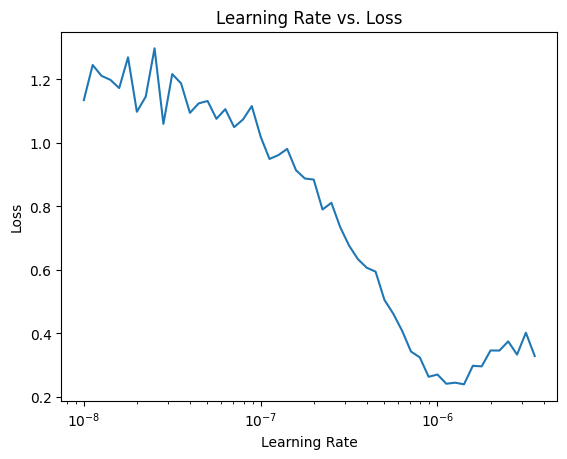

In [8]:
import matplotlib.pyplot as plt

# Plot learning rate vs loss
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate vs. Loss")
plt.show()


In [11]:
total_sequences = len(features_seq)
print("Total sequences available:", total_sequences)
# Make predictions on the test dataset
test_predictions = model.predict(test_features)


Total sequences available: 16
1/1 [==============================] - 2s 2s/step


In [12]:
print(test_predictions)

[[[ 0.1962124 ]
  [ 0.05562392]
  [-0.37412742]
  [-0.21537612]
  [-0.08931492]
  [ 0.08106254]
  [-0.02973659]
  [-0.12208821]
  [-0.28039554]
  [ 0.144816  ]
  [ 0.5050832 ]
  [ 0.36699602]
  [ 0.10137357]
  [-0.12324977]
  [-0.07833205]
  [ 0.18053226]
  [ 0.44304907]
  [ 0.56398493]
  [ 0.36278448]
  [ 0.24341972]
  [ 0.13147362]]

 [[ 0.19443549]
  [ 0.07058674]
  [-0.33607468]
  [-0.16727199]
  [-0.03053386]
  [ 0.13522874]
  [ 0.02771078]
  [-0.06435563]
  [-0.23541959]
  [ 0.18812181]
  [ 0.54082483]
  [ 0.39976427]
  [ 0.11169225]
  [-0.12950727]
  [-0.09143163]
  [ 0.16848116]
  [ 0.43953174]
  [ 0.56581813]
  [ 0.37565106]
  [ 0.25260773]
  [ 0.1457413 ]]

 [[ 0.19438104]
  [ 0.0709862 ]
  [-0.33521765]
  [-0.1662554 ]
  [-0.02884449]
  [ 0.13693927]
  [ 0.02976255]
  [-0.06260891]
  [-0.2338217 ]
  [ 0.18942134]
  [ 0.54162925]
  [ 0.40025455]
  [ 0.11202687]
  [-0.13009442]
  [-0.09190415]
  [ 0.16815399]
  [ 0.43953365]
  [ 0.5655388 ]
  [ 0.37503257]
  [ 0.25263768]
  [ 

In [13]:
print("Current shape of test_predictions:", test_predictions.shape)


Current shape of test_predictions: (5, 21, 1)


In [14]:
test_pre = test_predictions[0,:]
print(test_pre)
testPre = test_pre[:,0]
print(testPre)

[[ 0.1962124 ]
 [ 0.05562392]
 [-0.37412742]
 [-0.21537612]
 [-0.08931492]
 [ 0.08106254]
 [-0.02973659]
 [-0.12208821]
 [-0.28039554]
 [ 0.144816  ]
 [ 0.5050832 ]
 [ 0.36699602]
 [ 0.10137357]
 [-0.12324977]
 [-0.07833205]
 [ 0.18053226]
 [ 0.44304907]
 [ 0.56398493]
 [ 0.36278448]
 [ 0.24341972]
 [ 0.13147362]]
[ 0.1962124   0.05562392 -0.37412742 -0.21537612 -0.08931492  0.08106254
 -0.02973659 -0.12208821 -0.28039554  0.144816    0.5050832   0.36699602
  0.10137357 -0.12324977 -0.07833205  0.18053226  0.44304907  0.56398493
  0.36278448  0.24341972  0.13147362]


In [32]:
print(test_target)
print(target)
testY = target[-21:]
print(testY)

[0.046869 0.049058 0.048929 0.04597  0.046049]
0      0.072374
1      0.046824
2      0.082349
3      0.033152
4      0.016716
         ...   
331    0.015647
332    0.014293
333    0.018456
334    0.057398
335    0.046049
Name: OT1, Length: 336, dtype: float64
315    0.032873
316    0.063358
317    0.056203
318    0.013562
319    0.008939
320    0.008816
321    0.007446
322    0.015371
323    0.001957
324    0.022273
325    0.021750
326    0.016477
327    0.015945
328    0.015948
329    0.019459
330    0.001637
331    0.015647
332    0.014293
333    0.018456
334    0.057398
335    0.046049
Name: OT1, dtype: float64


In [33]:
print(testY)
print(len(testY))

315    0.032873
316    0.063358
317    0.056203
318    0.013562
319    0.008939
320    0.008816
321    0.007446
322    0.015371
323    0.001957
324    0.022273
325    0.021750
326    0.016477
327    0.015945
328    0.015948
329    0.019459
330    0.001637
331    0.015647
332    0.014293
333    0.018456
334    0.057398
335    0.046049
Name: OT1, dtype: float64
21


In [17]:
print(testPre)

[ 0.1962124   0.05562392 -0.37412742 -0.21537612 -0.08931492  0.08106254
 -0.02973659 -0.12208821 -0.28039554  0.144816    0.5050832   0.36699602
  0.10137357 -0.12324977 -0.07833205  0.18053226  0.44304907  0.56398493
  0.36278448  0.24341972  0.13147362]


In [34]:
testY = testY.to_numpy()


In [35]:
print(testY.shape)

(21,)


In [19]:
print(testY)

[0.032873 0.063358 0.056203 0.013562 0.008939 0.008816 0.007446 0.015371
 0.001957 0.022273 0.02175  0.016477 0.015945 0.015948 0.019459 0.001637
 0.015647 0.014293 0.018456 0.057398]


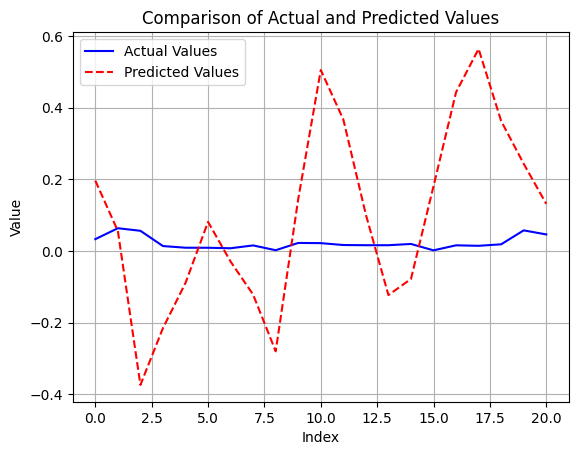

In [36]:
import matplotlib.pyplot as plt

# Assuming test_target is correctly aligned with test_predictions
# plt.figure(figsize=(12, 6))
plt.plot(testY, label='Actual Values', linestyle='-', color='blue')
plt.plot(testPre, label='Predicted Values', linestyle='--', color='red')
plt.title('Comparison of Actual and Predicted Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
import pandas as pd

# Create a DataFrame with both testY and testPre
data = {
    'Actual Values': testY,
    'Predicted Values': testPre
}
df = pd.DataFrame(data)
# Saving the DataFrame to a CSV file
df.to_csv('predictions_comparison_OT1.csv', index=False)
# Saving each vector to its own CSV file
df_actual = pd.DataFrame(testY, columns=['Actual Values'])
df_predicted = pd.DataFrame(testPre, columns=['Predicted Values'])

df_actual.to_csv('actual_valuesOT1.csv', index=False)
df_predicted.to_csv('predicted_valuesOT1.csv', index=False)


In [40]:
# Loading the CSVs to verify their contents
loaded_actual = pd.read_csv('actual_values.csv')
loaded_predicted = pd.read_csv('predicted_values.csv')

print(loaded_actual.head())
print(loaded_predicted.head())


   Actual Values
0       0.032873
1       0.063358
2       0.056203
3       0.013562
4       0.008939
   Predicted Values
0          0.196212
1          0.055624
2         -0.374127
3         -0.215376
4         -0.089315
